In [17]:
import pandas as pd
import sys
sys.path.append('../')
from src.utils import load_json
from sklearn.model_selection import train_test_split
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
tqdm.pandas()

# HELP FUNCTIONS

In [18]:
def stratified_train_valid_test_split(X, y, train_size=0.85, valid_size=0.05, test_size=0.10, random_state=42):
    """
    Perform a stratified train, validation, and test split.

    Parameters:
    - X: Features
    - y: Labels or target variable
    - train_size: Proportion of the dataset to include in the train split (default: 0.85)
    - valid_size: Proportion of the dataset to include in the validation split (default: 0.05)
    - test_size: Proportion of the dataset to include in the test split (default: 0.10)
    - random_state: Seed for reproducibility (default: None)

    Returns:
    - X_train, X_valid, X_test, y_train, y_valid, y_test
    """

    # Perform the first split to separate training set and temporary data
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(valid_size + test_size), stratify=y, random_state=random_state)

    # Perform the second split to separate validation set and test set
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=(test_size / (valid_size + test_size)), stratify=y_temp, random_state=random_state)

    return X_train, X_valid, X_test, y_train, y_valid, y_test

def plot_tsne(data, target):
    # separate data
    X = np.array([embeddings for embeddings in data[target].to_list()])
    y = data['predictions']

    # build tsne
    tsne = TSNE(n_components=2, random_state=42, perplexity=3)
    X_tsne = tsne.fit_transform(X)
    tsne.kl_divergence_
    
    # plot
    df_tsne = pd.DataFrame(data=X_tsne, columns=['tsne1', 'tsne2'])
    df_tsne['label'] = y

    # Plot using Seaborn
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='tsne1', y='tsne2', hue='label', data=df_tsne, palette='viridis', legend='full')
    plt.title('t-SNE Visualization')
    plt.show()

def build_terms_ratios_by_class(df: pd.DataFrame, feature: str,  class_feature: int, min_frequency: int = 30) -> dict():
    """Builds a distribuition of terms of the target class_feature."""
    # positive, negative and total counts
    remain_reasons = Counter()
    target_reason = Counter()
    total_counts = Counter()
    # Loop all conversations and count for each class the words and the total of it.
    for _, row  in df.iterrows():
        for n in [1]:
            for grams in ngrams(row['frase'].split(" "), n):
                grams = ' '.join(grams)
                if(row[feature] == class_feature):
                    target_reason[grams] += 1
                    total_counts[grams] += 1
                else:
                    remain_reasons[grams] += 1
                    total_counts[grams] += 1 

    reasons_ratios = Counter()
    # Calculate the ratios of company speaker and client uses of the most common words
    for term,cnt in list(total_counts.most_common()):
        if(cnt > min_frequency):
            ratio = target_reason[term]/(float(remain_reasons[term]) + 1)
            reasons_ratios[term] = ratio

    # Convert ratios to logs
    for word,ratio in reasons_ratios.most_common():
        reasons_ratios[word] = np.log(ratio + 0.01)

    return(reasons_ratios, total_counts)

def clip_weights(weights: Counter(), min: float, max: float) -> Counter():
    """ Clip weights between range min max."""
    clipped_weights = Counter()
    for word, weight in zip(weights.keys(), weights.values()):
        if weight < min or weight > max:
            clipped_weights[word] = weight

    return(clipped_weights)

def replace_text(text: str, company_ratios: Counter, padding: int) -> list():
    """ Tokenize text"""
    tokens = Counter()
    for grams in ngrams(text.split(" "),1):
        grams = ' '.join(grams)
        try:
            if company_ratios[grams] != 0:
                tokens[grams] = company_ratios[grams]
        except KeyError: # jump word
            continue
    
    # padding
    tokens = [weight for weight in tokens.values()]
    if len(tokens) < padding:
        size_tokens = len(tokens)
        to_append = padding - size_tokens
        tokens = np.append(tokens, np.zeros(to_append))
    else:
        tokens = tokens[0:padding]
    return(tokens)

def transf_to_numpy(data: pd.DataFrame, feature: str) -> np.array:
    """ Transform list of tokens to numpy array"""
    arr_list = data[feature].tolist()
    arr_list = [np.array(x) for x in arr_list]
    numpy_array = np.vstack(arr_list)
    return(numpy_array)

def transf_to_array(df, feature):
    final = []
    for _, row in df.iterrows():
        final.append(np.array(row[feature]))
    return(final)
    

# 1 - Load Data & Predictions

Nesta fase é importante olhar minimamente para os dados para não ter vazamento dos dados, inclusive no EDA.

In [26]:
train = pd.read_csv('../data/raw/dataset_train.csv', sep="|")
json_predictions = load_json('../data/predictions/train.json')
train['predictions'] = json_predictions

In [27]:
train.head()

,Unnamed: 0,input,predictions
0,0,judging from previous posts this used to be a ...,NEGATIVE
1,1,"we , there were four of us , arrived at noon -...",NEGATIVE
2,2,"they never brought us complimentary noodles , ...",NEGATIVE
3,3,the food was lousy - too sweet or too salty an...,NEGATIVE
4,4,"after all that , they complained to me about t...",NEGATIVE


In [28]:
train.drop(columns='Unnamed: 0', inplace=True)

# PREPROCESSING

In [ ]:
train.predictions.value_counts()

predictions
POSITIVE                      3759
NEUTRAL                       2626
NEGATIVE                      2432
Classification: NE              13
Classify: NE                     7
POSITIVE                         6
NEUTRAL                          4
Classified as:                   2
Class: NEUT                      2
Classification: POS              2
Classified as NE                 2
Classify: NEG                    2
NEGATIVE                         2
Classification: NEG              2
Classified: NEG                  1
Classified: NE                   1
food and service were both       1
Classified as NEG                1
Name: count, dtype: int64

**Observações**:


Como são poucas linhas que tem o erro nos dados de TREINO vou apenas dropar estes.

Esse problema é comum, dependendo do input o modelo de LLM pode não responder bem. Aparentemente existe uma MISTURA de produtos. A expectativa é que este fosse um grupo de reviews sobre RESTAURANTES e mesmo assim tem comentários sobre TI. Esse  pode ser um motivo para o LLM não manter o padrão [NEGATIVE, POSITIVE, NEUTRAL].

## Tag Correction & Drop 

In [29]:
# correct tags with wrong spaces
train.loc[:,'predictions'] = train['predictions'].str.strip()

# drop incorrect tags
train = train[train.predictions.isin(['NEGATIVE','NEUTRAL','POSITIVE'])]
train.predictions.value_counts()

predictions
POSITIVE    3765
NEUTRAL     2630
NEGATIVE    2434
Name: count, dtype: int64

# SPLIT TRAIN, VALID, TEST

*   Os dados de Treino irão ser usados para treinar e testar o processo de treino e validação.
*   Os dados de Validação serão utilizados para fazer fine-tunning no modelo escolhido.
*   Os dados de Teste não serão mais visualizados e processados para que possamos testar nossa hipótese(modelo) construida da amostra da população.(TREINO & VALIDAÇÃO)

In [30]:
train.input

0       judging from previous posts this used to be a ...
1       we , there were four of us , arrived at noon -...
2       they never brought us complimentary noodles , ...
3       the food was lousy - too sweet or too salty an...
4       after all that , they complained to me about t...
                              ...                        
8860    Outstanding Bagels , but you get what you pay ...
8861             The sides were ok and incredibly salty .
8862    While the menu is n't especially groundbreakin...
8863                             It 's just O.K . pizza .
8864                      But the coconut rice was good .
Name: input, Length: 8829, dtype: object

In [31]:
X_train, X_valid, X_test, y_train, y_valid, y_test = stratified_train_valid_test_split(train['input'], train.drop(columns='input'))

print("Train set size:", len(X_train))
print("Validation set size:", len(X_valid))
print("Test set size:", len(X_test))

Train set size: 7504
Validation set size: 441
Test set size: 884


In [16]:
train = pd.concat([X_train, y_train], axis=1)
train.head()

,input,predictions
7657,Took the netbook on a vacation trip and I was ...,POSITIVE
8749,I highly recommend Caviar Russe to anyone who ...,POSITIVE
2123,"For $760 for 2 people, it's a once in a lifeti...",NEUTRAL
1275,surprised that a place of this caliber would a...,NEGATIVE
7218,"However , my girlfriend realized that the netb...",NEUTRAL


# EDA

## Top Modelation
*   Vamos avaliar primeiramente quais tópicos se apresentam neste dataset. Por uma avalição visual foi possível identificar dois grupos: COMIDA e TI. É importante conseguir isolar todo tópico que não seja COMIDA e elimna-los, caso contrário podem trazer sujeira e limitar o modelo.

In [17]:
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(train['input'])

In [18]:
topics_df = topic_model.get_topic_info()

In [19]:
topics_df.head(30)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,2509,-1_the_and_to_of,"[the, and, to, of, we, it, was, for, you, in]","[We had a good time., Nothing to complain abou..."
1,0,168,0_laptop_this_computer_bought,"[laptop, this, computer, bought, notebook, mar...","[Overall this laptop is great ., I bought this..."
2,1,166,1_mac_macbook_pro_pc,"[mac, macbook, pro, pc, book, macs, my, easy, ...",[I will have to say that I love my MacBook Pro...
3,2,146,2_room_bathroom_clean_rooms,"[room, bathroom, clean, rooms, bed, small, ver...","[The bathroom was a little small , but clean ...."
4,3,129,3_hotel_booked_nice_this,"[hotel, booked, nice, this, stayed, very, host...","[The hotel was very nice ., Great Hotel !, ver..."
5,4,127,4_pizza_crust_pizzeria_pizzas,"[pizza, crust, pizzeria, pizzas, fresh, slice,...","[It's just O.K. pizza., The pizza was great., ..."
6,5,123,5_nyc_york_ny_manhattan,"[nyc, york, ny, manhattan, new, brooklyn, in, ...",[every time in new york i make it a point to v...
7,6,121,6_waitress_waiter_waiters_she,"[waitress, waiter, waiters, she, us, asked, ru...",[One would think we'd get an apology or compli...
8,7,101,7_food_was_average_tasty,"[food, was, average, tasty, above, good, hot, ...","[The food was good too., The food was great., ..."
9,8,99,8_food_dog_dogs_hot,"[food, dog, dogs, hot, delicious, prepared, go...","[Food is great., The food is great., The food ..."


### **Observaçoes**:

Existem uma boa quantidade de tópicos COMIDA, TI, HOTEIS, etc.

Por hora vou separar os reviews relacionados a comida e restaurante.

## Separar Tópicos [Embedding + Clusterização]

Vamos ver se é possível identificar o grupo COMIDA criando um embedding e aplicando clusterização.

In [20]:
# Embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings =  train['input'].progress_apply(lambda input: model.encode(input))

100%|██████████| 7504/7504 [04:24<00:00, 28.38it/s]


In [21]:
# get embeddings
train['embeddings'] = embeddings

# build clusters
dbscan = DBSCAN(eps=0.92, min_samples=25)
clusters = dbscan.fit_predict(train['embeddings'].to_list())

# get clusters
train['clusters'] = clusters

In [25]:
train['clusters'].value_counts()

clusters
-1    3622
 0    3078
 1     804
Name: count, dtype: int64

In [26]:
train[train.clusters==0].input.to_list()

['be sure not to get anything other than bagels ! . .',
 'During our meal, the management came over and checked on us and even bought us a round of drinks.',
 'Great wine list , reasonably priced . -- Sara',
 'Their whitefish salad is excellent--all whitefish with a little mayo.',
 'the price very reasonable .',
 'The service was the only thing good about this restaurant.',
 'We spent $200 in this place and left hungry and very disappointed.',
 'Really excelent hotel , clean and beautiful room , comprehensive choice of delicious food and drinks in different restaurant , beach near the hotel , very nice people ( animators , waiters , cooks , receptionist , cleaning men ... ) , great animations program · step aerobic , oriental dance and specially water gym : · ) and at night disco .',
 'The place is sleek, modern and playfull and i will return again frequently.',
 "You won't find that anywhere in Manhattan.",
 "But they've done a really nice job of offering all the typical pizzeria fave

In [24]:
train[train.clusters==1].input.to_list()

['Took the netbook on a vacation trip and I was able to do whatever I wanted to do without lugging a much heavier laptop .',
 "I'ts nice to have the higher-end laptops , but this fits my budget and the features I need .",
 'PC users work in Word , while Mac users work in Pages .',
 'Great laptop that offers many great features !',
 'Before I got my macbook , I owned a Dell laptop .',
 'After years of using PCs , a new Mac user is basically forced to re-learn how to use a computer .',
 'After years of occasionally pulling my hair out fighting computer viruses , a good friend convinced me it was time to go the Apple route .',
 'I investigated netbooks and saw the Toshiba NB305-N410BL .',
 'It has easy to use features and all the speed and power I could ask for .',
 'Even so , I like playing online games , so it was wonderful that there is a feature where I can dualboot Windows .',
 'I got assurances from 2 different people that the remaining 10 months of my warranty would transfer to the

In [64]:
train[train.clusters==-1].input.to_list()

['I highly recommend Caviar Russe to anyone who wants delicious top grade caviar and fantastic service .',
 "For $760 for 2 people, it's a once in a lifetime experience.",
 'surprised that a place of this caliber would advertise it as kobe .',
 "However , my girlfriend realized that the netbook 's hinge is a bit loose ( when you open or close the LCD ) .",
 'I also had a problem with the touchpad that caused the mouse pointer to jump all over the screen .',
 "Not too much `` junk '' software to remove .",
 "· Didn 't recieve a bill",
 'we had a great time at the jekyll and hyde pub last night .',
 "What appeared to be Eastern Europeans were noisy at the pool areas and mostly ignored the ' no jumping ' signs , they were also rude and pushy at service areas of dining rooms .",
 'Based on a visit a month ago, I returned the week before Christmas and was hugely disappointed.',
 'It ’s within walking distance of Rome ’s most important sights .',
 'at taj, vegetarians can rejoice-all the dis

### **Obervações**:

Vou optar por separar estes reviews mas para isso vou carregar novamente os dados separar e fazer o split, para uma separação justa entre TEST, TREINO e VALIDAÇAO.

In [32]:
# load
data = pd.read_csv('../data/raw/dataset_train.csv', sep="|")
json_predictions = load_json('../data/predictions/train.json')
data['predictions'] = json_predictions


data.drop(columns='Unnamed: 0', inplace=True)
# correct tags with wrong spaces
data.loc[:,'predictions'] = data['predictions'].str.strip()

# drop incorrect tags
data = data[data.predictions.isin(['NEGATIVE','NEUTRAL','POSITIVE'])]
data.predictions.value_counts()

# Embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings =  data['input'].progress_apply(lambda input: model.encode(input))

# get embeddings
data['embeddings'] = embeddings

100%|██████████| 8829/8829 [04:12<00:00, 34.90it/s]


In [33]:
# build clusters
dbscan = DBSCAN(eps=0.9, min_samples=25)
clusters = dbscan.fit_predict(data['embeddings'].to_list())

# get clusters
data['clusters'] = clusters
data['clusters'].value_counts()

clusters
-1    4719
 0    3267
 1     843
Name: count, dtype: int64

In [34]:
data[data.clusters == 0].input.to_list()

['the food was lousy - too sweet or too salty and the portions tiny .',
 'i have eaten at saul , many times , the food is always consistently , outrageously good .',
 'saul is the best restaurant on smith street and in brooklyn .',
 'the wine list is interesting and has many good values .',
 'for the price , you can not eat this well in manhattan .',
 'i was very disappointed with this restaurant .',
 'food was okay , nothing great .',
 'i / we will never go back to this place again .',
 'went on a 3 day oyster binge , with fish bringing up the closing , and i am so glad this was the place it o trip ended , because it was so great !',
 "service was devine , oysters where a sensual as they come , and the price ca n ' t be beat ! ! !",
 'every time in new york i make it a point to visit restaurant saul on smith street .',
 'everything is always cooked to perfection , the service is excellent , the decor cool and understated .',
 "and i hate to say this but i doubt i ' ll ever go back .",

In [35]:
data[data.clusters == 1].input.to_list()


['it was well worth the wait .',
 'super fast processor and really nice graphics card ..',
 'Toshiba is aware of the issue but unless the extended warrenty is bought Toshiba will do nothing about it .',
 'This is my first Dell I heard their customer service was lacking and that they were working on improving it !',
 "I will definitely be getting a new laptop if it has any more issues after the warranty expires and researching carefully when I do so I do n't run accross a situation like this again !",
 'After having two PC laptops die with in the past 3 years , I was led to the Apple display at Best Buy by the sleek design and promise of less tech issues .',
 'PC users work in Word , while Mac users work in Pages .',
 'Battery is lasting about 6 hours as I am surfing the web on Sundays while checking football scores and watching funny Youtube videos .',
 'As a user of a PC , I will will admit that the macBook Pro has a better running system in which I found myself `` Getting the job don

In [36]:
data[data.clusters == -1].input.to_list()

['judging from previous posts this used to be a good place , but not any longer .',
 'we , there were four of us , arrived at noon - the place was empty - and the staff acted like we were imposing on them and they were very rude .',
 'they never brought us complimentary noodles , ignored repeated requests for sugar , and threw our dishes on the table .',
 'after all that , they complained to me about the small tip .',
 'avoid this place !',
 'the duck confit is always amazing and the foie gras terrine with figs was out of this world .',
 'ive asked a cart attendant for a lotus leaf wrapped rice and she replied back rice and just walked away .',
 'i had to ask her three times before she finally came back with the dish ive requested .',
 'chow fun was dry ; pork shu mai was more than usually greasy and had to share a table with loud and rude family .',
 "you ca n ' t go wrong here .",
 'i had the duck breast special on my last visit and it was incredible .',
 "i had never had edamame pur

In [37]:
food_reviews = data[data.clusters == 0].drop(columns='clusters')
X_train, X_valid, X_test, y_train, y_valid, y_test = stratified_train_valid_test_split(food_reviews['input'], food_reviews.drop(columns=['embeddings','input']))

print("Train set size:", len(X_train))
print("Validation set size:", len(X_valid))
print("Test set size:", len(X_test))

food_reviews = pd.concat([X_train, y_train], axis=1)
food_reviews.head()

Train set size: 2776
Validation set size: 163
Test set size: 328


,input,predictions
5747,"A nice hotel , good food",POSITIVE
2020,Highly recommend this as great value for excel...,POSITIVE
8764,"I have been there many times , and food is goo...",POSITIVE
3942,And they have these home made potato chips at ...,POSITIVE
1264,"one of the best , if not the best , restaurant...",POSITIVE


### **Observações**

Vou salvar estes arquivos em uma pasta para processamento posterior. O ideal aqui é criar um pipeline de processamento automatizado, mas por causa do prazo não vale a pena automatizar essa etapa.

In [38]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
valid = pd.concat([X_valid, y_valid], axis=1)

train.to_csv('../data/to_process/train.csv', index=False)
test.to_csv('../data/to_process/test.csv', index=False)
valid.to_csv('../data/to_process/valid.csv', index=False)

## Plot - Positive, Negative & Neutral

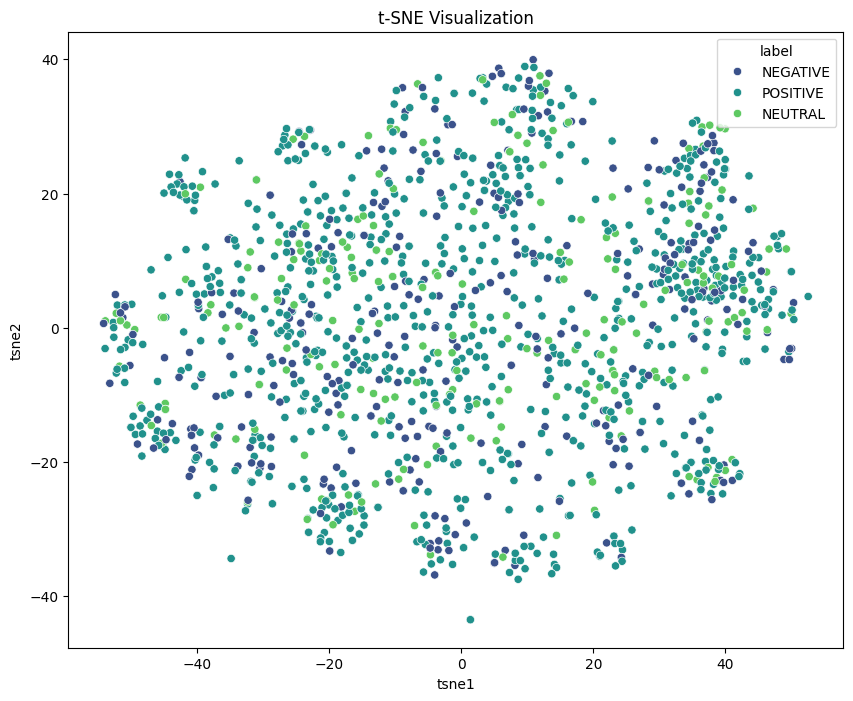

In [132]:
plot_tsne(food_reviews)

### **Observaçoes**:

Com uma redução drástica de 384 dimensões para 2 é esperado que não traga resultados interessantes mas pela facilidade de uso vale a pena tentar.

Mas o ideal é fazer um plot 3D! Fica pra mais tarde.

## Contagem de Palavras entre classes

In [39]:
class build_terms_ratios_by_class:
    def __init__(self,data: pd.DataFrame, sentiments_column: str, reviews_column: str, min_frequency: int = 5, balanced: float = 0.38):
        self.data = data
        self.sentiments_column = sentiments_column 
        self.reviews_column = reviews_column 
        self.min_frequency = min_frequency
        self.balanced_weight = balanced
        
        self.positive_sentiment_counter = Counter()
        self.negative_sentiment_counter = Counter()
        self.neutral_sentiment_counter = Counter()
        self.total_counter = Counter()
        self.positive_negative_ratio = Counter()
        
    @staticmethod
    def append_word_count(sentiment_counter: Counter(), total_counter: Counter(), word: str) -> Counter:
        sentiment_counter[word] += 1
        total_counter[word] += 1 
        return(sentiment_counter, total_counter)       
    
    @staticmethod
    def clip_weights(weights: Counter(), min: float, max: float) -> Counter():
        """ Clip weights between range min max."""
        clipped_weights = Counter()
        for word, weight in zip(weights.keys(), weights.values()):
            if weight < min or weight > max:
                clipped_weights[word] = weight

        return(clipped_weights)
   
    @staticmethod
    def replace_text(text: str, company_ratios: Counter, padding: int) -> list():
        """ Tokenize text"""
        tokens = Counter()
        for word in text.split(" "):
            try:
                if company_ratios[word] != 0:
                    tokens[word] = company_ratios[word]
            except KeyError: # jump word
                print(word)
                continue
        
        # padding
        tokens = [weight for weight in tokens.values()]
        if len(tokens) < padding:
            size_tokens = len(tokens)
            to_append = padding - size_tokens
            tokens = np.append(tokens, np.zeros(to_append))
        else:
            tokens = tokens[0:padding]
        return(tokens)

    def word_counter(self):
        for _, row  in tqdm(self.data.iterrows()):
            for word in row[self.reviews_column].split(" "):
                if row[self.sentiments_column] == 'POSITIVE':
                    self.append_word_count(self.positive_sentiment_counter, self.total_counter, word)
                elif row[self.sentiments_column] == 'NEGATIVE':
                    self.append_word_count(self.negative_sentiment_counter, self.total_counter, word)
                    
    def positive_negative_ratio_calc(self):
        for term,cnt in list(self.total_counter.most_common()):
            if(cnt > self.min_frequency):
                ratio = self.positive_sentiment_counter[term]/((float(self.negative_sentiment_counter[term]) + 1)/self.balanced_weight)
                self.positive_negative_ratio[term] = ratio
                
    def ratios2logs(self):
        for word,ratio in self.positive_negative_ratio.most_common():
            self.positive_negative_ratio[word] = np.log(ratio + 0.01)
            
    def pipeline(self):
        self.word_counter()
        self.positive_negative_ratio_calc()
        self.ratios2logs()

In [40]:
build = build_terms_ratios_by_class(food_reviews, 'predictions', 'input')

In [41]:
build.pipeline()

0it [00:00, ?it/s]

2776it [00:00, 2893.23it/s]


In [42]:
build.positive_negative_ratio.most_common()[0:30]

[('wonderful', 2.4989739069994354),
 ('love', 2.434490163873984),
 ('perfect', 2.400618833265411),
 ('amazing', 2.329227023940467),
 ('friendly', 2.304250372313107),
 ('helpful', 2.169053700369523),
 ('delicious', 2.062210604751474),
 ('Great', 2.054123733695546),
 ('fantastic', 2.0294631718735943),
 ('great', 1.9738495177445547),
 ('highly', 1.8066480817218056),
 ('spot', 1.8066480817218056),
 ('city', 1.673351238177753),
 ('date', 1.673351238177753),
 ('good.', 1.673351238177753),
 ('loved', 1.5993875765805987),
 ('prompt', 1.5993875765805987),
 ('large', 1.5993875765805987),
 ('shrimp', 1.5993875765805987),
 ('pleasant', 1.5993875765805987),
 ('excellent', 1.588360186831204),
 ('fresh', 1.5195132049061133),
 ('trip', 1.5195132049061133),
 ('Excellent', 1.5195132049061133),
 ('cozy', 1.5195132049061133),
 ('reasonably', 1.5195132049061133),
 ('favorite', 1.4770487243883548),
 ('terrific', 1.4327007339340463),
 ('style', 1.4327007339340463),
 ('Everything', 1.4327007339340463)]

In [43]:
list(reversed(build.positive_negative_ratio.most_common()))[0:30]

[('lack', -4.605170185988091),
 ('slow', -4.605170185988091),
 ('horrible', -4.605170185988091),
 ('rude', -4.605170185988091),
 ('lousy', -4.605170185988091),
 ('worst', -4.605170185988091),
 ('bland', -4.605170185988091),
 ('overpriced', -3.111245160675835),
 ('seems', -2.8559703311788325),
 ('actually', -2.8559703311788325),
 ('expect', -2.8559703311788325),
 ('else', -2.8559703311788325),
 ('cold', -2.744417845273085),
 ('hard', -2.744417845273085),
 ('bill', -2.6127400212978853),
 ('guests', -2.6127400212978853),
 ('bad', -2.6127400212978853),
 ('although', -2.3597435068339943),
 ('asked', -2.3597435068339943),
 ('..', -2.2537949288246137),
 ('rather', -2.2537949288246137),
 ('poor', -2.2537949288246137),
 ('order', -2.2537949288246137),
 ('average', -2.174751721484161),
 ('sometimes', -2.132239727246807),
 ("wasn't", -2.132239727246807),
 ('sweet', -1.9902104079518932),
 ('expected', -1.9902104079518932),
 ('bring', -1.9902104079518932),
 ('After', -1.9902104079518932)]

array([[<Axes: title={'center': '0'}>]], dtype=object)

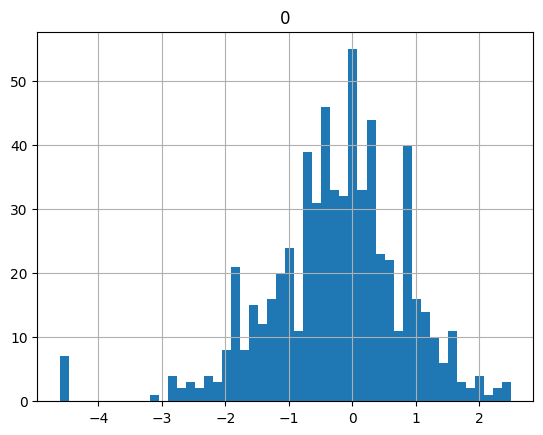

In [44]:
pd.DataFrame(list(build.positive_negative_ratio.values())).hist(bins=50)

In [45]:
positive_negative_ratios_clipped = build.clip_weights(max=0.3, min=-0.3, weights=build.positive_negative_ratio)

array([[<Axes: title={'center': '0'}>]], dtype=object)

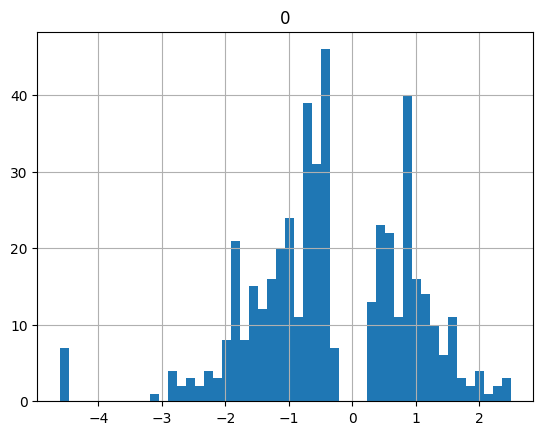

In [46]:
pd.DataFrame(list(positive_negative_ratios_clipped.values())).hist(bins=50)

#### **Observações**

É possível já ver claramente quais palavras se destacam e geram peso para cada lado. Mas ainda é necessário **normaliza-las** para que seja possível ter melhores resultados. Importante notar que as palavras que aparecem em ambos tem pesos aproximados de 0, o que significa que podemos elimina-los já que não vão agregar e apenas sujar os dados.

Outro aspecto importante é sobre a classificaçao NEUTRA, ela não foi levada em consideração de propósito. Temos os pesos das palavras positivas e negativas e iremos cortar o meio (-0.2 - 0.2) com isso é esperado que as sentenas neutras fiquem com uma grande quantidade de pesos 0 (padding) o que vai facilitar o modelo reconhece-la.

### 3D Plot Pesos

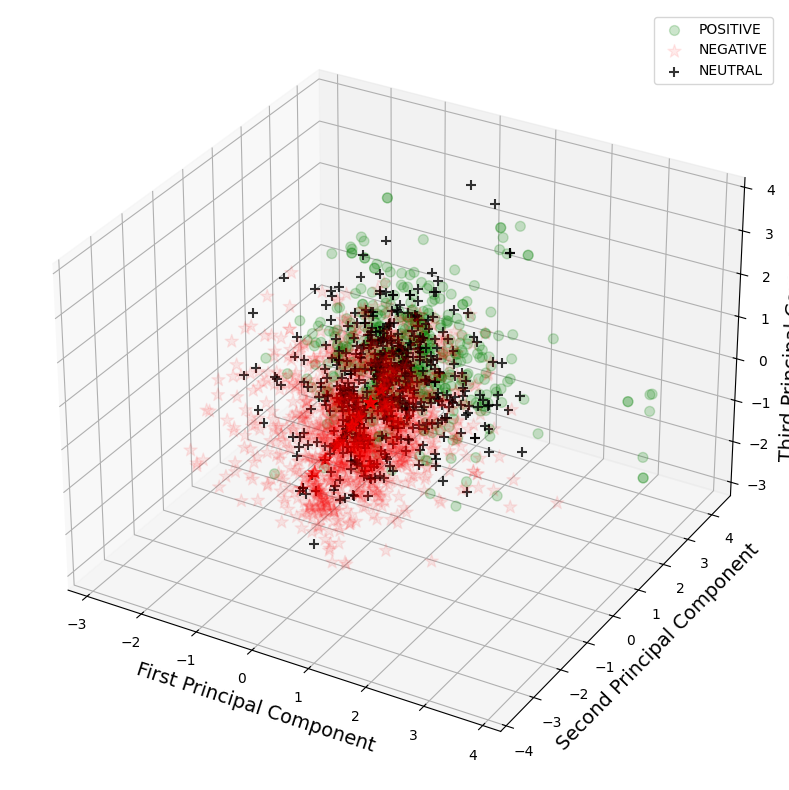

In [49]:
# tokens to numpy
food_reviews['TEXT_tokens'] = food_reviews.input.apply(lambda text: build.replace_text(text, positive_negative_ratios_clipped, 5))
arr_list = food_reviews['TEXT_tokens'].tolist()
arr_list = [np.array(x) for x in arr_list]


label_to_int = {'NEGATIVE': 0, 'POSITIVE': 1, 'NEUTRAL': 2}
y_int = food_reviews['predictions'].map(label_to_int)

# get X,y
X = np.vstack(arr_list)
y = food_reviews['predictions']

# scaller data
scaler = StandardScaler()
scaler.fit(X) 
X_scaled = scaler.transform(X)

# PCA 
pca = PCA(n_components=3)
pca.fit(X_scaled) 
X_pca = pca.transform(X) 

Xax = X_pca[:,2]
Yax = X_pca[:,0]
Zax = X_pca[:,1]

cdict = {1:'red',0:'green', 2:'black'}
labl = {1:'NEGATIVE',0:'POSITIVE', 2:'NEUTRAL'}
marker = {1:'*',0:'o', 2:'+'}
alpha = {1:.08, 0:.2, 2:.8}

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

fig.patch.set_facecolor('white')
for l in np.unique(y_int):
  ix=np.where(y_int==l)
  if l == 1:
    s=100
  else:
    s=50
  ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=cdict[l], s=s,
          label=labl[l], marker=marker[l], alpha=alpha[l])
# for loop ends
ax.set_xlabel("First Principal Component", fontsize=14)
ax.set_ylabel("Second Principal Component", fontsize=14)
ax.set_zlabel("Third Principal Component", fontsize=14)

ax.legend()
plt.show()

### **Observações**
Como esperado, positivos e negativos separados pelo neutro. Os modelos não vão ter muitos problemas em lidar com essas separação. E é esperado um valor maior de FP e FN com o sentimento NEUTRO. Neste caso vai ser importante escolher bem a métrica a ser utilizada. Por hora um FBetaScore pode ser o ideal, com foco nos sentimentos NEGATIVOS. É importante que tenhamos mais FP no sentimento NEGATIVO porque na monitoria se um review passar desperceibo o cliente pode perder dinheiro. Existem diversos estudos que mostram o desbalanceamento entre reviews POSITIVOS e NEGATIVOS, sendo o último com maior peso!